In [1]:
import scipy.io
data = scipy.io.loadmat('data.mat')

import numpy as np
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Bias5', 'Bias_avg', 'DR_event_idx', 'K', 'MAPE5', 'MAPE_avg', 'NARE5', 'NARE_avg', 'customer', 'days', 'event_period', 'flag', 'i', 'test5'])


In [2]:
data['customer'][0][0][1][0][0]
# [customer]表示数据集的名称
# 第二个[]表示custmoer底下的内容，由于只有一份，故为0
# 第三个[]表示选取的行数,即为选取哪个用户
# 第四个[0]内容为选取用户的id，[1]表示用户数据
# 第五个[]表示选取结构体的行数,即为单个用户的表示的小时数
# 第六个[]表示列数，即为天数(171)

# 建立存储每名用户的字典
dict_user = {}
num_of_user = len(data['customer'][0])
print('num_of_user:',num_of_user)
num_of_day = len(data['customer'][0][0][1][0])
print("num_of_day:",num_of_day)

# dict_user{}存储每个用户的数据列表的字典
for user_index in range(num_of_user-3000):
    temp_data = []
    for i in range(num_of_day):
        for j in range(24):
            temp_data.append(data['customer'][0][user_index][1][j][i])
    dict_user[user_index] = temp_data

print(np.array(dict_user[0]).shape)

num_of_user: 3637
num_of_day: 171
(4104,)


In [3]:
# 制作单个用户的数据集，以id:1002用户为例
dataset_1002 = []
id = 3000   # 用户id
for i in range(171):
    for j in range(24):
        dataset_1002.append(data['customer'][0][id-1002][1][j][i])
dataset_1002 = np.array(dataset_1002, dtype=np.float32)
print(dataset_1002.shape)
print(len(dataset_1002))

(4104,)
4104


In [4]:
# 计算自相关系数
def ac_calculate(num_list, lag_num=24*7):
    # 计算自协方差
    mean_num_list = np.mean(np.array(num_list))
    auto_conv_total = 0
    for i in range(len(num_list) - lag_num):
        auto_conv_total += (num_list[i] - mean_num_list)*(num_list[i+lag_num]-mean_num_list)
    auto_conv = auto_conv_total/(len(num_list)-lag_num)
    # 计算均方差
    error_total = 0
    for i in range(len(num_list)):
        error_total += (num_list[i] - mean_num_list)**2
    error = error_total/len(num_list)
    return auto_conv/error

from random import shuffle
import time

num_cluster  = 10
# 读取用户数据的序号
X = dict_user.keys()
X = list(X)

# 随机打乱用户序号
shuffle(X)
# print(X)
cluster = [[x] for x in X[:num_cluster]]
print(cluster)

dict_cluster = {}
for i in range(10):
    dict_cluster[i] = dict_user[cluster[i][0]]
print(dict_cluster.keys())

# 聚类操作(Greedy)
for list_index in range(len(X)-num_cluster):
    T = time.time()
    dict_cluster_temp = dict_cluster
    for dict_index in range(num_cluster):
        for i in range(len(dict_user[X[list_index + num_cluster]])):
            dict_cluster_temp[dict_index][i] += dict_user[X[list_index + num_cluster]][i]
    dict_record ={}
    for index in range(num_cluster):
        dict_record[index] = ac_calculate(dict_cluster_temp[index]) - ac_calculate(dict_cluster[index])
    max_ac_increase = dict_record[0]
    max_num = 0
    for i in range(num_cluster-1):
        if dict_record[i+1] > max_ac_increase:
            max_ac_increase = dict_record[i+1]
            max_num = i + 1
    for i in range(len(dict_user[X[list_index + num_cluster]])):
        dict_cluster[max_num][i] += dict_user[X[list_index + num_cluster]][i]
    print(time.time()-T)

[[633], [370], [91], [559], [149], [246], [622], [24], [303], [390]]
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
0.06499481201171875
0.0689995288848877
0.07099509239196777
0.07612895965576172
0.06598377227783203
0.06590986251831055
0.07097721099853516
0.06299948692321777
0.0690004825592041
0.07009530067443848
0.07690238952636719
0.0710296630859375
0.06790685653686523
0.06800270080566406
0.06800317764282227
0.0769963264465332
0.06708765029907227
0.06991100311279297
0.07808995246887207
0.07299304008483887
0.07092618942260742
0.07297587394714355
0.06611371040344238
0.0689699649810791
0.06902503967285156
0.06889224052429199
0.07400226593017578
0.0700829029083252
0.06800532341003418
0.06799888610839844
0.0669107437133789
0.07300019264221191
0.0710911750793457
0.06990814208984375
0.07700228691101074
0.08299803733825684
0.07000184059143066
0.07099723815917969
0.06599974632263184
0.06900310516357422
0.06700944900512695
0.09499144554138184
0.06710600852966309
0.06699991226196289
0.068906784057617

In [5]:
# 数据最大最小值标准化
max(dict_cluster[0])
min(dict_cluster[0])
def standardlize(num_list):
    max_num = max(num_list)
    min_num = min(num_list)
    for index in range(len(list(num_list))):
        num_list[index] = (num_list[index] - min_num)/(max_num-min_num)
    return num_list, max_num, min_num
dict_cluster[0], max_num,min_num = standardlize(dict_cluster[0])

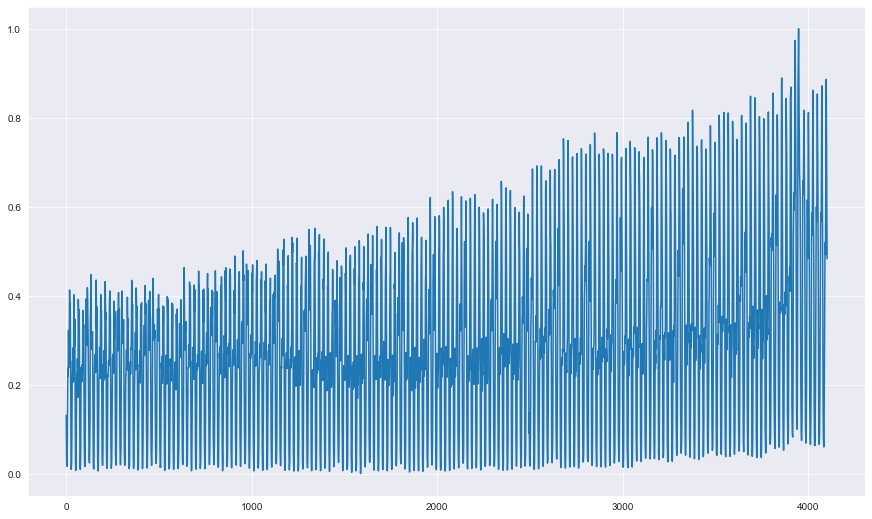

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

# scaler = MinMaxScaler(feature_range=(0,1))
# dataset_1002 = scaler.fit_transform(dataset_1002)
sns.set_style("darkgrid")
plt.figure(figsize=(280,105))
plt.plot(dataset_1002,linewidth =5, label="consumption")
plt.legend(loc="upper right", fontsize = 300)
plt.xlabel("time/(hour)", fontsize=300)
plt.ylabel("consumption/(kw)", fontsize = 300)
fig = plt.gcf()
plt.show()
fig.savefig("total")

In [7]:
def split_data(stock, lookback):
    data = []
    
    for index in range(len(stock)-lookback):
        data.append(stock[index:index + lookback])
    
    
    data = np.array(data, dtype=np.float32)
    # data = scale(data, with_mean=False, with_std=False)
    print(data.shape)
    
    test_set_size = int(np.round(0.3 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = np.array(data[:train_set_size,:-25], dtype=np.float32)
    y_train = np.array(data[:train_set_size, -1], dtype=np.float32)
    
    x_test = np.array(data[train_set_size:,:-25], dtype=np.float32)
    y_test = np.array(data[train_set_size:,-1], dtype=np.float32)
    return x_train, y_train, x_test, y_test

In [8]:
x_train, y_train, x_test, y_test = split_data(dict_cluster[0], 337)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(3767, 337)
(2637, 312)
(2637,)
(1130, 312)
(1130,)


In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch.utils.data as Data


#将数据集转化为张量 并处理为PyTorch网络使用的数据
train_xt=torch.from_numpy(x_train.astype(np.float32))
train_yt=torch.from_numpy(y_train.astype(np.float32))
test_xt=torch.from_numpy(x_test.astype(np.float32))
test_yt=torch.from_numpy(y_test.astype(np.float32))
#将数据处理为数据加载器
train_data=Data.TensorDataset(train_xt,train_yt)
test_data=Data.TensorDataset(test_xt,test_yt)
train_loader=Data.DataLoader(dataset=train_data,batch_size=5,shuffle=True,num_workers=0)

In [10]:
#搭建MLP回归模型
class MLPregression(nn.Module):
    def __init__(self):
        super(MLPregression,self).__init__()
        #定义第一个隐藏层
        self.hidden1=nn.Linear(in_features=312 ,out_features=20,bias=True)#8*100 8个属性特征
        # #定义第二个隐藏层
        # self.hidden2=nn.Linear(100,100)#100*100
        # #定义第三个隐藏层
        # self.hidden3=nn.Linear(100,50)#100*50
        #回归预测层
        self.predict=nn.Linear(20,1)#50*1  预测只有一个 房价
    def forward(self,x):
        sigmoid = nn.Sigmoid()
        x=sigmoid(self.hidden1(x))
        # x=F.relu(self.hidden2(x))
        # x=F.relu(self.hidden3(x))
        output=self.predict(x)
        return output[:,0]
mlpreg=MLPregression()
print(mlpreg)

MLPregression(
  (hidden1): Linear(in_features=312, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
)


Epoch: 0 Loss: 0.020028418499170628
Epoch: 1 Loss: 0.007244083878712144
Epoch: 2 Loss: 0.004626445359257546
Epoch: 3 Loss: 0.0038653228536435743
Epoch: 4 Loss: 0.003503264733334575
Epoch: 5 Loss: 0.003296029279357158
Epoch: 6 Loss: 0.0031862758805455797
Epoch: 7 Loss: 0.0030820994441022502
Epoch: 8 Loss: 0.0029761846797063513
Epoch: 9 Loss: 0.002899967301859793
Epoch: 10 Loss: 0.002846885958698082
Epoch: 11 Loss: 0.0027755005124794107
Epoch: 12 Loss: 0.002715387081044742
Epoch: 13 Loss: 0.00266086539976895
Epoch: 14 Loss: 0.0026078558967249344
Epoch: 15 Loss: 0.0025486081878693155
Epoch: 16 Loss: 0.002506694600035874
Epoch: 17 Loss: 0.0024544646409974595
Epoch: 18 Loss: 0.0024182062652392034
Epoch: 19 Loss: 0.002382151668270887
Epoch: 20 Loss: 0.0023331681077514263
Epoch: 21 Loss: 0.002306523787279636
Epoch: 22 Loss: 0.0022690108033373083
Epoch: 23 Loss: 0.002229135707112806
Epoch: 24 Loss: 0.002193760881255175
Epoch: 25 Loss: 0.002165659087334547
Epoch: 26 Loss: 0.0021393356920668557


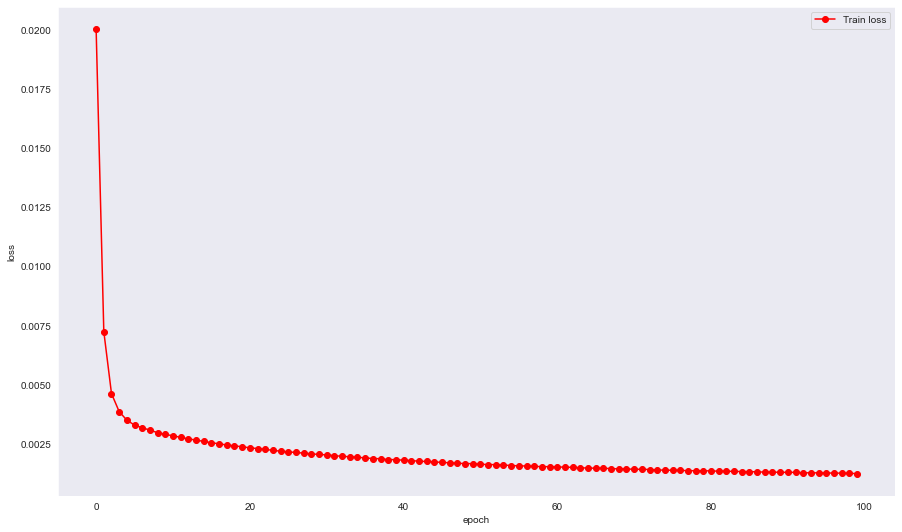

In [11]:
#定义优化器
optimizer=torch.optim.SGD(mlpreg.parameters(),lr=0.01)
loss_func=nn.MSELoss()
train_loss_all=[]
for epoch in range(100):
    train_loss=0
    train_num=0
    for step,(b_x,b_y) in enumerate(train_loader):
        output=mlpreg(b_x)
        loss=loss_func(output,b_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()*b_x.size(0)
        train_num+=b_x.size(0)
    print("Epoch:",epoch,"Loss:",train_loss/train_num)
    train_loss_all.append(train_loss/train_num)
plt.figure(figsize=(15,9))
plt.plot(train_loss_all,"ro-",label="Train loss")
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

1130
RMSE is tensor(0.0770)
NRMSE is 0.11644051418764477


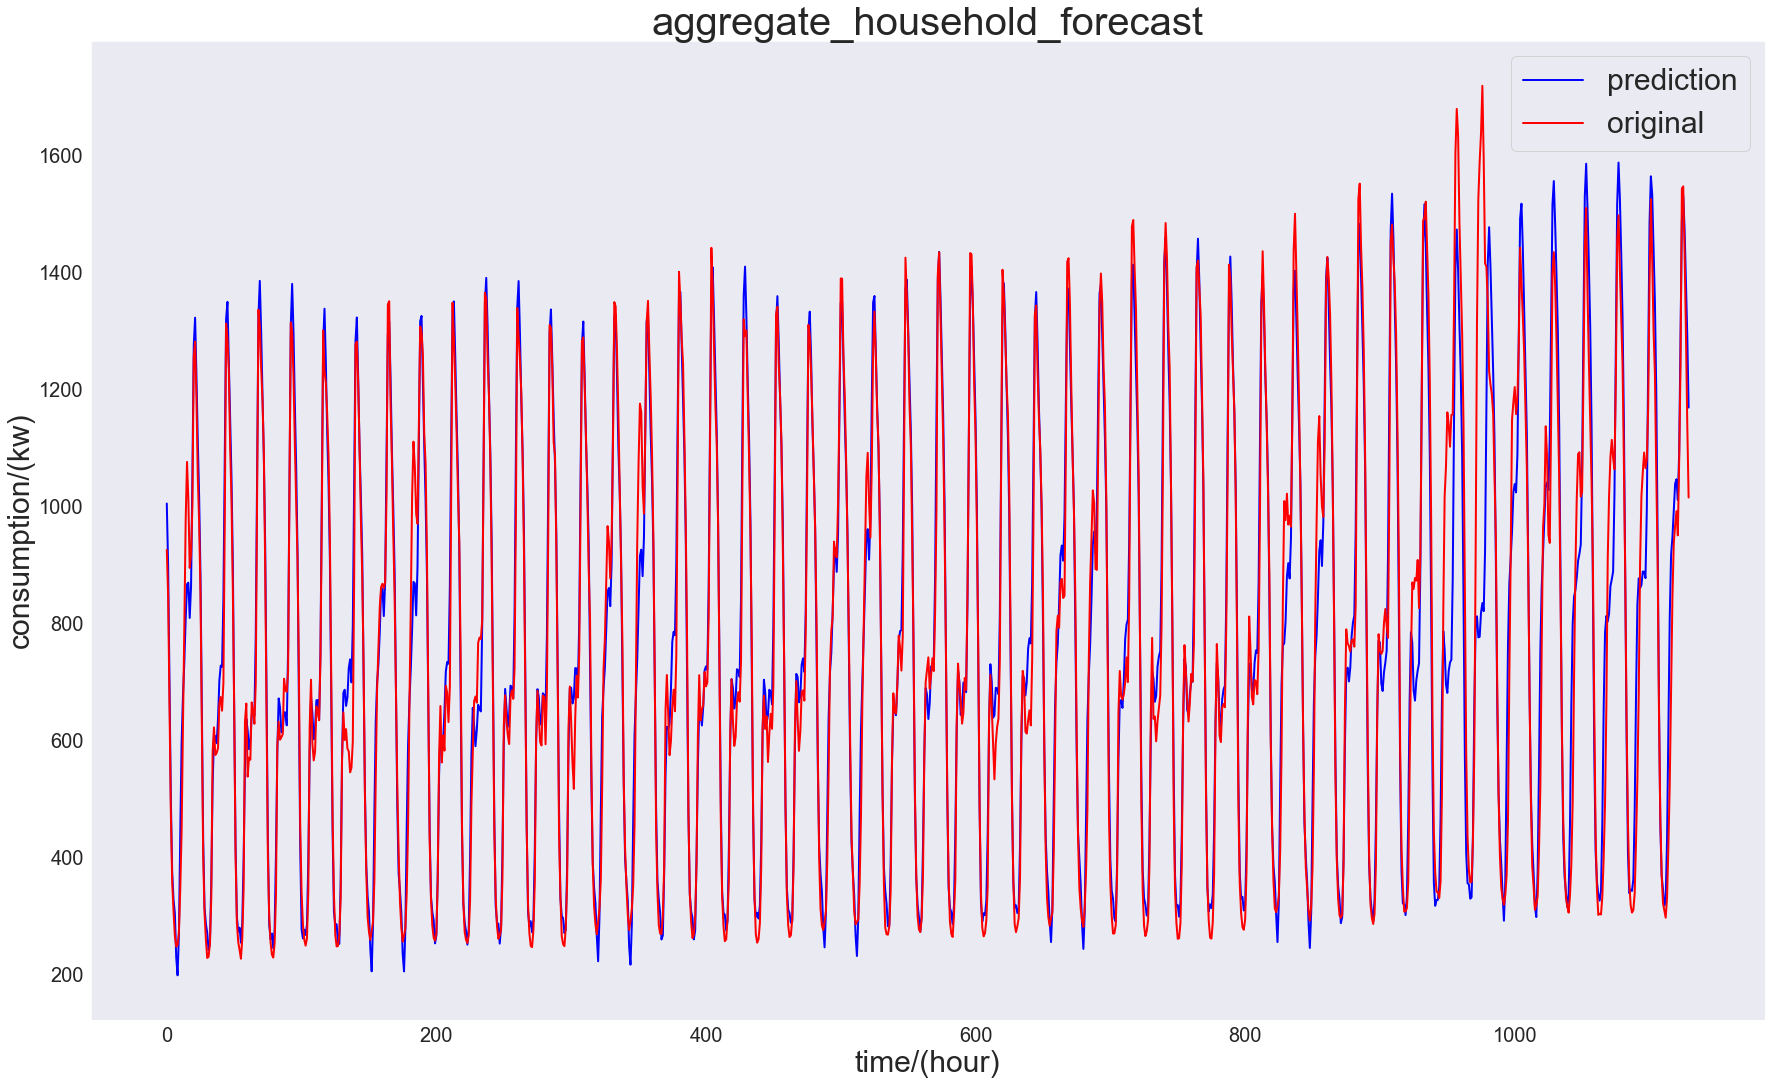

In [12]:
#预测
from cProfile import label
import math

pre_y=mlpreg(test_xt)
pre_y=pre_y.data.numpy()
for index in range(len(list(pre_y))):
    pre_y[index] = pre_y[index] * (max_num - min_num) + min_num
# print(pre_y)
test_yt = test_yt
for index in range(len(list(test_yt))):
    test_yt[index] = test_yt[index] * (max_num - min_num) + min_num
print(len(pre_y))
# mae=mean_absolute_error(y_test,pre_y)
MAE,S1,RMSE,S2 = 0,0,0,0
for index in range(len(pre_y)):
    MAE += abs(pre_y[index]-test_yt[index])
    RMSE += (pre_y[index]-test_yt[index])**2
    S1 += abs(test_yt[index])
    S2 += test_yt[index]**2
    
NMAE = MAE/S1
NRMSE = math.sqrt(RMSE/S2)
print("RMSE is", NMAE)
print("NRMSE is", NRMSE)

# index=np.argsort(y_test)
sns.set_style("darkgrid")
plt.figure(figsize=(30,18))
plt.rcParams.update({"font.size":20})
x=plt.title("aggregate_household_forecast",fontsize=40)
plt.plot(np.arange(1130), pre_y, c="b", label="prediction",linestyle="-",linewidth=2, marker='')
plt.plot(np.arange(1130), test_yt, c="r", label="original",linestyle="-",linewidth=2,marker="")
plt.legend(loc="upper right",fontsize=30)
# plt.plot(np.arange(len(y_test)),y_test[index],"r",label="original y")
# plt.scatter(np.arange(len(pre_y)),pre_y[index],s=3,c="b",label="prediction")
# plt.legend(loc="upper left")
plt.grid()
plt.xlabel("time/(hour)", fontsize=30)
plt.ylabel("consumption/(kw)", fontsize = 30)
fig = plt.gcf()
plt.show()
fig.savefig("success.jpg")
#'-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
